## LOADING WATER LEVELS DATA

In [1]:
import pandas as pd
import numpy as np

In [2]:
noweKaczkowo_hq = pd.read_csv('./BROK/noweKaczkowo_hq.csv', index_col='date')
gostkowo_hq = pd.read_csv('./BROK/gostkowo_hq.csv', index_col='date')

Creating data frame (hq) for modeling

In [3]:
hq = pd.merge(noweKaczkowo_hq, gostkowo_hq, how='left', on='date')
hq.head()

,H_x,Q_x,H_y,Q_y
date,,,,
1981-01-01,218.0,7.58,252.0,3.54
1981-01-02,238.0,9.31,268.0,4.66
1981-01-03,248.0,10.40,258.0,3.96
1981-01-04,266.0,12.60,326.0,12.90
1981-01-05,350.0,24.20,330.0,14.00


In [4]:
hq = hq.rename(columns={'H_x':'H_kaczkowo', 'Q_x':'Q_kaczkowo', 'H_y':'H_gostkowo', 'Q_y':'Q_gostkowo'})
hq.head()

,H_kaczkowo,Q_kaczkowo,H_gostkowo,Q_gostkowo
date,,,,
1981-01-01,218.0,7.58,252.0,3.54
1981-01-02,238.0,9.31,268.0,4.66
1981-01-03,248.0,10.40,258.0,3.96
1981-01-04,266.0,12.60,326.0,12.90
1981-01-05,350.0,24.20,330.0,14.00


In [5]:
hq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14610 entries, 1981-01-01 to 2021-12-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   H_kaczkowo  14610 non-null  float64
 1   Q_kaczkowo  14610 non-null  float64
 2   H_gostkowo  11323 non-null  float64
 3   Q_gostkowo  11323 non-null  float64
dtypes: float64(4)
memory usage: 570.7+ KB


Replace all NaN elements with 0s

In [6]:
hq.fillna(0, inplace=True)

In [7]:
hq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14610 entries, 1981-01-01 to 2021-12-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   H_kaczkowo  14610 non-null  float64
 1   Q_kaczkowo  14610 non-null  float64
 2   H_gostkowo  14610 non-null  float64
 3   Q_gostkowo  14610 non-null  float64
dtypes: float64(4)
memory usage: 570.7+ KB


## MODELS

### CASE 1: FORECASTING WATER LEVELS FOR THE NOWE KACZKOWO STATION, ASSUMING THAT THIS WATER GAUGE PROFILE REPRESENTS AN INCOMPLETE SET OF DATA ON WATER LEVELS

In [8]:
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import hydroeval as he
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [9]:
# split into train and test sets
train_dataset = hq['1981-01-01':'2003-12-31']
test_dataset = hq['2004-01-01':'2004-12-31']

In [10]:
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

Dimension of train data:  (8400, 4)
Dimension of test data:  (366, 4)


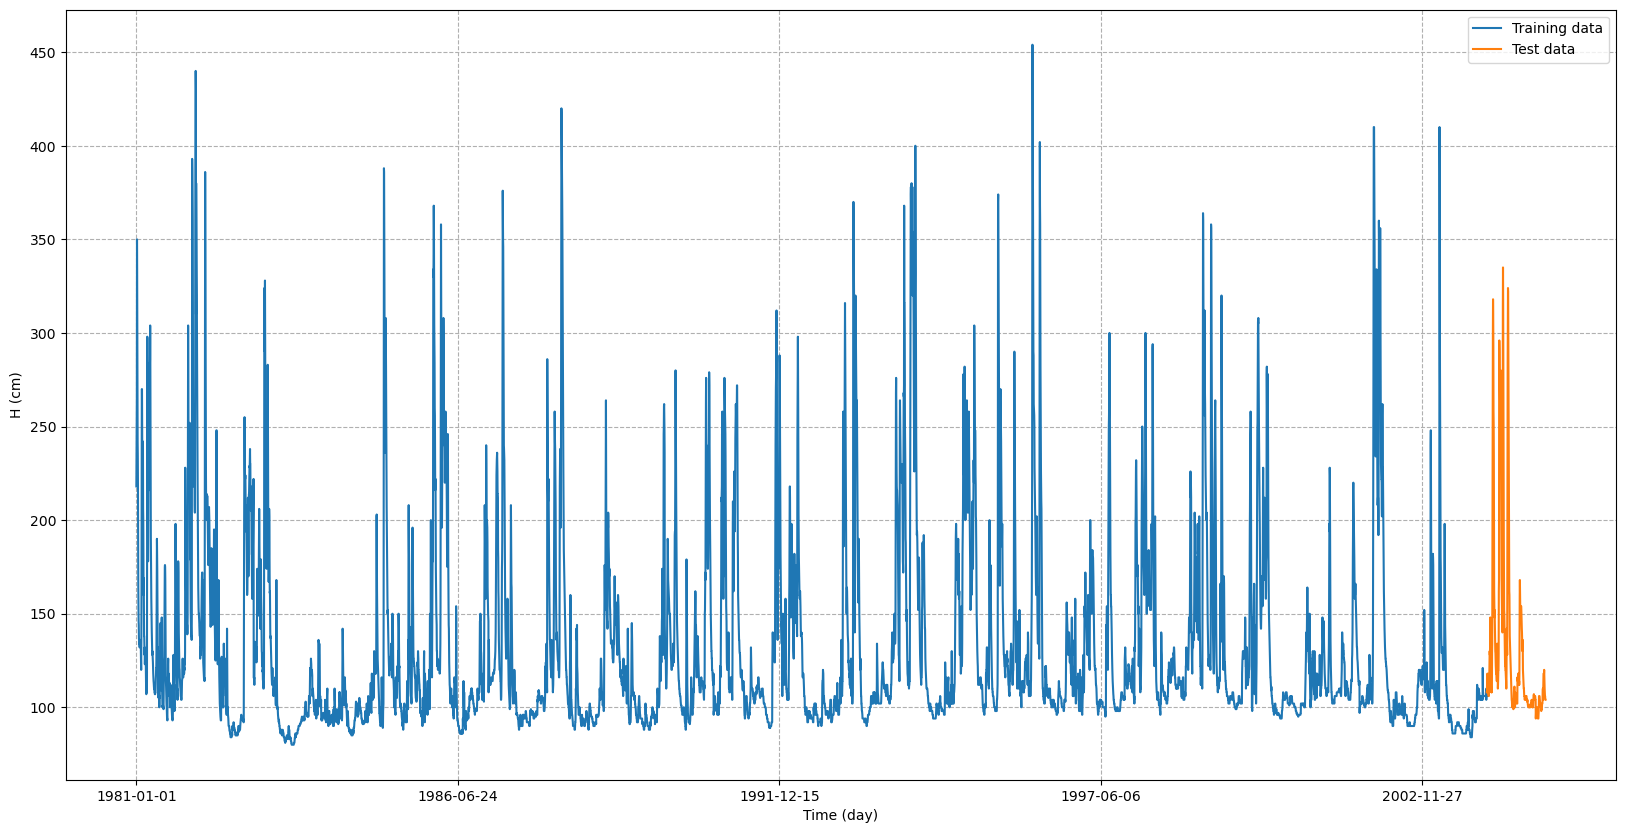

In [11]:
# Plot train and test data
plt.figure(figsize = (20, 10))
plt.plot(train_dataset.H_kaczkowo)
plt.plot(test_dataset.H_kaczkowo)
plt.xlabel('Time (day)')
plt.ylabel('H (cm)')
plt.legend(['Training data', 'Test data'], loc='upper right')
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_locator(ticker.AutoLocator())

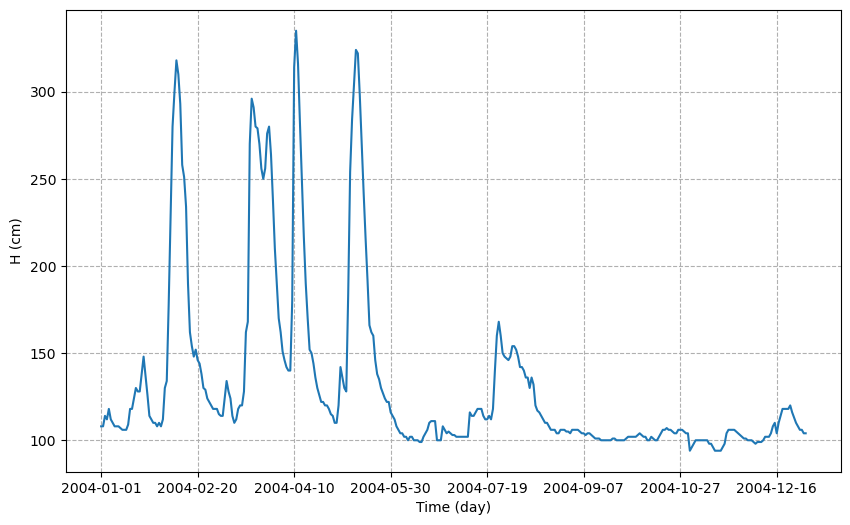

In [12]:
# Plot test data
plt.figure(figsize = (10, 6))
plt.plot(test_dataset.H_kaczkowo)
plt.xlabel('Time (day)')
plt.ylabel('H (cm)')
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_locator(ticker.AutoLocator())

In [13]:
# Split train data to X and y
X_train = train_dataset.drop(['Q_kaczkowo','H_kaczkowo','Q_gostkowo'], axis = 1)
y_train = train_dataset.loc[:,['H_kaczkowo']]

# Split test data to X and y
X_test = test_dataset.drop(['Q_kaczkowo','H_kaczkowo','Q_gostkowo'], axis = 1)
y_test = test_dataset.loc[:,['H_kaczkowo']]

In [14]:
X_train.head()

,H_gostkowo
date,
1981-01-01,252.0
1981-01-02,268.0
1981-01-03,258.0
1981-01-04,326.0
1981-01-05,330.0


In [15]:
X_test.head()

,H_gostkowo
date,
2004-01-01,172.0
2004-01-02,172.0
2004-01-03,171.0
2004-01-04,170.0
2004-01-05,168.0


In [16]:
y_train.head()

,H_kaczkowo
date,
1981-01-01,218.0
1981-01-02,238.0
1981-01-03,248.0
1981-01-04,266.0
1981-01-05,350.0


In [17]:
y_test.head()

,H_kaczkowo
date,
2004-01-01,108.0
2004-01-02,108.0
2004-01-03,114.0
2004-01-04,112.0
2004-01-05,118.0


#### DECISION TREE  MODEL

In [18]:
# Create regression tree model
model_dt = DecisionTreeRegressor()

# Create parameters grid
param_grid_dt = {
    'max_depth': [None, 2, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20, 40, 60],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}
# Grid search for optimization
grid_search_dt = GridSearchCV(model_dt, param_grid_dt, cv=5, scoring='neg_mean_absolute_error')
grid_search_dt.fit(X_train, y_train)

# Choosing the best model
best_model_dt = grid_search_dt.best_estimator_

In [19]:
print(best_model_dt)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, min_samples_split=60)


In [20]:
# Make prediction
prediction_dt = best_model_dt.predict(X_test)

#### RANDFOM FOREST MODEL

In [21]:
# Create regression forest model
model_rf = RandomForestRegressor()

# Grid search for optimization
param_grid_rf = {
    'n_estimators': [2, 5, 10, 20, 50, 100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20, 40, 60],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}
# Grid search for optimization
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='neg_mean_absolute_error')
grid_search_rf.fit(X_train, y_train.values.ravel())

# Choosing the best model
best_model_rf = grid_search_rf.best_estimator_

In [22]:
print(best_model_rf)

RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=40,
                      n_estimators=5)


In [23]:
# Make prediction
prediction_rf = best_model_rf.predict(X_test)

#### RESULTS

In [24]:
# Plot observed vs predicted
def plot_prediction(prediction, y_test):
    plt.figure(figsize=(20, 10))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='H observed')     
    plt.plot(np.arange(range_future),np.array(prediction), 
            label='H predicted', color='Red')
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('H (cm)')
    plt.grid(linestyle='--')

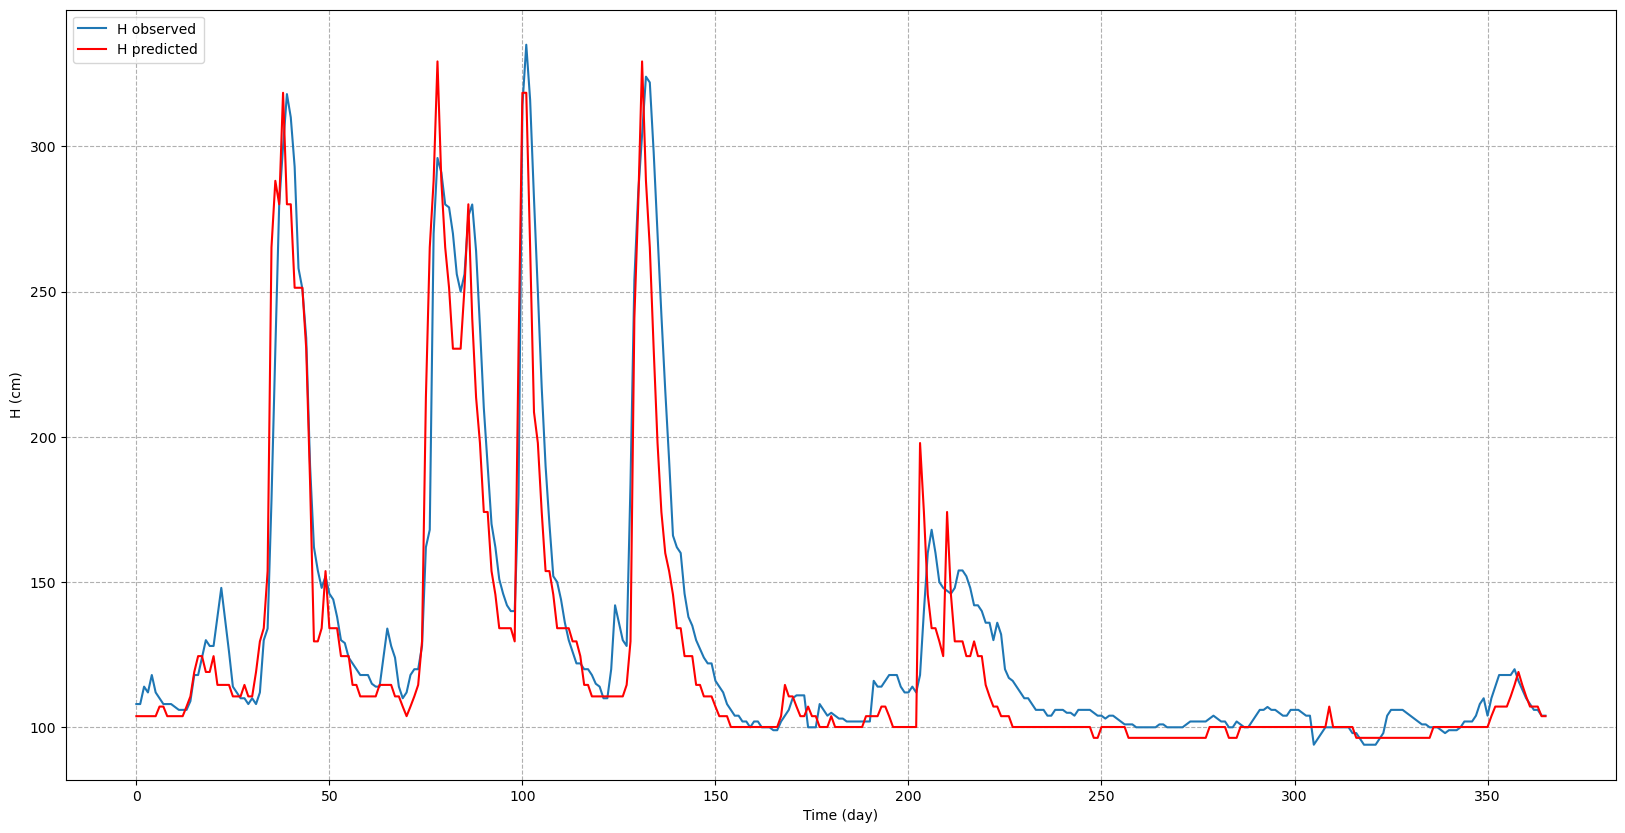

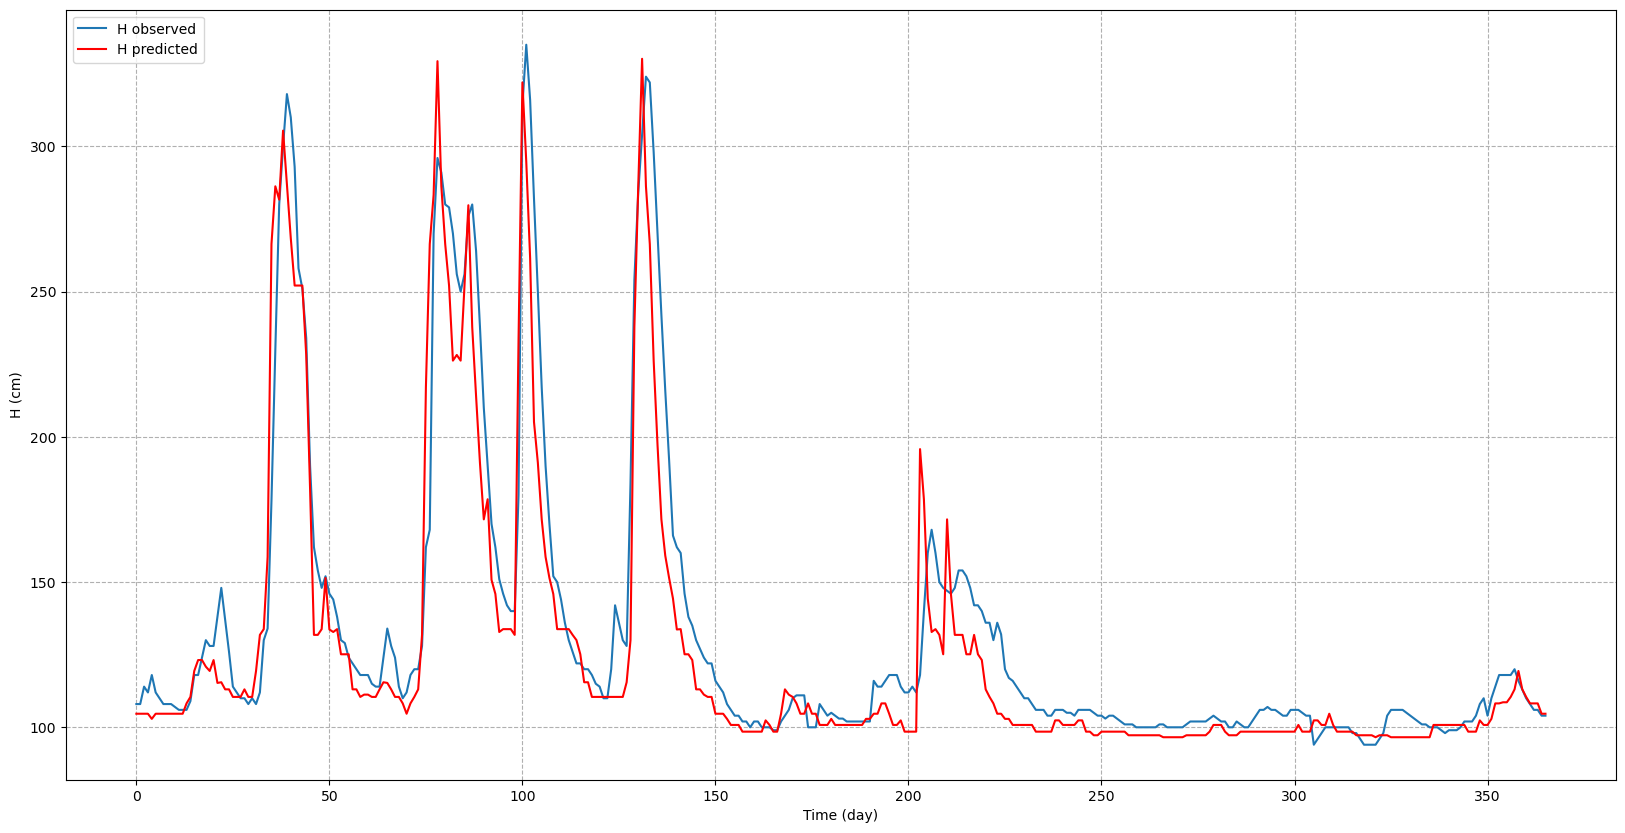

In [25]:
plot_prediction(prediction_dt, y_test)
plot_prediction(prediction_rf, y_test)

In [26]:
def print_evaluation1():
    nse_dt = he.evaluator(he.nse, prediction_dt, y_test)
    nse_rf = he.evaluator(he.nse, prediction_rf, y_test) 
    r2_dt = r2_score(prediction_dt, y_test)
    r2_rf = r2_score(prediction_rf, y_test)
    
    print('Nash-Sutcliffe Efficiency')
    print('Decission Tree:',f'{float(nse_dt):.2f}')
    print('Random Forest:',f'{float(nse_rf):.2f}')
    print('')
    
    print('R2 score')
    print('Decission Tree:',f'{float(r2_dt):.2f}')
    print('Random Forest:',f'{float(r2_rf):.2f}')
    print('')

In [27]:
print_evaluation1()

Nash-Sutcliffe Efficiency
Decission Tree: 0.88
Random Forest: 0.87

R2 score
Decission Tree: 0.86
Random Forest: 0.85



#### RNN MODELS

In [28]:
# Scaler for input and output
X_scaler = MinMaxScaler(feature_range = (0,1))
y_scaler = MinMaxScaler(feature_range = (0,1))

in_scaler = X_scaler.fit(X_train)
out_scaler = y_scaler.fit(y_train)

X_train_norm = in_scaler.transform(X_train)
y_train_norm = out_scaler.transform(y_train)

X_test_norm = in_scaler.transform(X_test)
y_test_norm = out_scaler.transform(y_test)

In [29]:
# Create a 3D input
def create_dataset(X, y, window):
    Xdata, ydata = [], []
    for i in range(len(X)-window):
        a = X[i:(i+window)]
        Xdata.append(a)
        ydata.append(y[i+window])
    return np.array(Xdata), np.array(ydata)

In [30]:
DAYS = 2
X_test, y_test = create_dataset(X_test_norm, y_test_norm, DAYS)
X_train, y_train = create_dataset(X_train_norm, y_train_norm, DAYS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (8398, 2, 1)
y_train.shape:  (8398, 1)
X_test.shape:  (364, 2, 1)
y_test.shape:  (364, 1)


In [31]:
# Create BiLSTM model
def create_model_bilstm(units_l, units_d, xs1, xs2):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units_l,
                                 input_shape=(xs1, xs2),
                                 activation='relu',
                                 return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units = units_l)))
    model.add(Dropout(0.1))
    model.add(Dense(units_d, activation='relu'))
    model.add(Dense(units_d, activation='relu'))
    model.add(Dense(units_d, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    #Compile model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mae', optimizer=optimizer)#RMSprop
    return model

In [32]:
# Create LSTM and GRU model
def create_model(units_l, units_d , m, xs1, xs2):
    model = Sequential()
    model.add(m(units=units_l, input_shape=(xs1, xs2), activation='relu',
               return_sequences=True))
    model.add(Dropout(0.1))
    model.add(m(units = units_l))
    model.add(Dropout(0.1))
    model.add(Dense(units_d, activation='relu'))
    model.add(Dense(units_d, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units_d, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    #Compile model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mae', optimizer=optimizer)
    return model

In [33]:
model_bilstm = create_model_bilstm(64, 64, X_train.shape[1], X_train.shape[2])
model_lstm = create_model(64, 64, LSTM, X_train.shape[1], X_train.shape[2])
model_gru = create_model(64, 64, GRU, X_train.shape[1], X_train.shape[2])

In [34]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 250,  
                        validation_split = 0.1, batch_size = 32,
                        shuffle = False, callbacks = [early_stop])
    return history

In [35]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/250
237/237 [==============================] - 10s 16ms/step - loss: 0.0852 - val_loss: 0.0625
Epoch 2/250
237/237 [==============================] - 3s 11ms/step - loss: 0.0558 - val_loss: 0.0278
Epoch 3/250
237/237 [==============================] - 3s 11ms/step - loss: 0.0360 - val_loss: 0.0282
Epoch 4/250
237/237 [==============================] - 3s 11ms/step - loss: 0.0358 - val_loss: 0.0285
Epoch 5/250
237/237 [==============================] - 2s 10ms/step - loss: 0.0361 - val_loss: 0.0284
Epoch 6/250
237/237 [==============================] - 2s 10ms/step - loss: 0.0360 - val_loss: 0.0287
Epoch 7/250
237/237 [==============================] - 2s 10ms/step - loss: 0.0361 - val_loss: 0.0296
Epoch 8/250
237/237 [==============================] - 3s 11ms/step - loss: 0.0363 - val_loss: 0.0286
Epoch 9/250
237/237 [==============================] - 3s 12ms/step - loss: 0.0362 - val_loss: 0.0289
Epoch 10/250
237/237 [==============================] - 3s 11ms/step - loss: 0.03

In [36]:
history_lstm = fit_model(model_lstm)

Epoch 1/250
237/237 [==============================] - 7s 14ms/step - loss: 0.0912 - val_loss: 0.0752
Epoch 2/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0765 - val_loss: 0.0547
Epoch 3/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0528 - val_loss: 0.0278
Epoch 4/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0383 - val_loss: 0.0299
Epoch 5/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0382 - val_loss: 0.0294
Epoch 6/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0380 - val_loss: 0.0298
Epoch 7/250
237/237 [==============================] - 2s 7ms/step - loss: 0.0376 - val_loss: 0.0298
Epoch 8/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0377 - val_loss: 0.0299
Epoch 9/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0376 - val_loss: 0.0295
Epoch 10/250
237/237 [==============================] - 2s 10ms/step - loss: 0.0381 - val_

In [37]:
history_gru = fit_model(model_gru)

Epoch 1/250
237/237 [==============================] - 6s 11ms/step - loss: 0.0821 - val_loss: 0.0535
Epoch 2/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0490 - val_loss: 0.0290
Epoch 3/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0381 - val_loss: 0.0303
Epoch 4/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0376 - val_loss: 0.0301
Epoch 5/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0374 - val_loss: 0.0310
Epoch 6/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0375 - val_loss: 0.0298
Epoch 7/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0371 - val_loss: 0.0311
Epoch 8/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0374 - val_loss: 0.0307
Epoch 9/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0374 - val_loss: 0.0310
Epoch 10/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0375 - val_l

In [38]:
#Inverse transform the target variable
y_test = y_scaler.inverse_transform(y_test)
y_train = y_scaler.inverse_transform(y_train)

In [39]:
print(y_test[:5])
print('-----------')
print(y_train[:5])

[[114.]
 [112.]
 [118.]
 [112.]
 [110.]]
-----------
[[248.]
 [266.]
 [350.]
 [330.]
 [292.]]


In [40]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = y_scaler.inverse_transform(prediction)
    return prediction

In [41]:
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

12/12 [==============================] - 1s 3ms/step


####  RESULTS

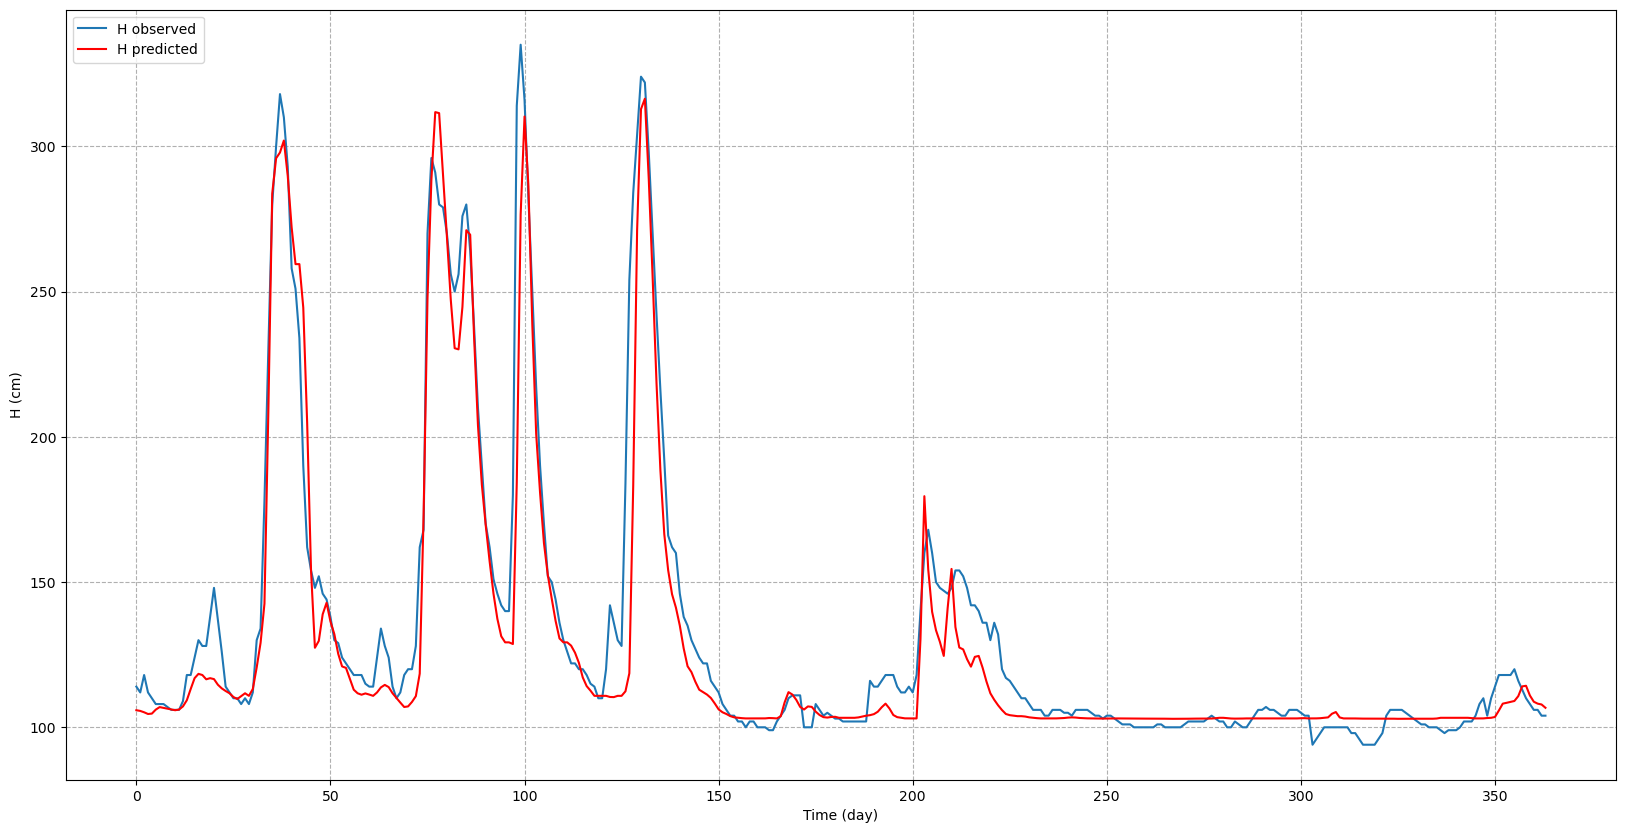

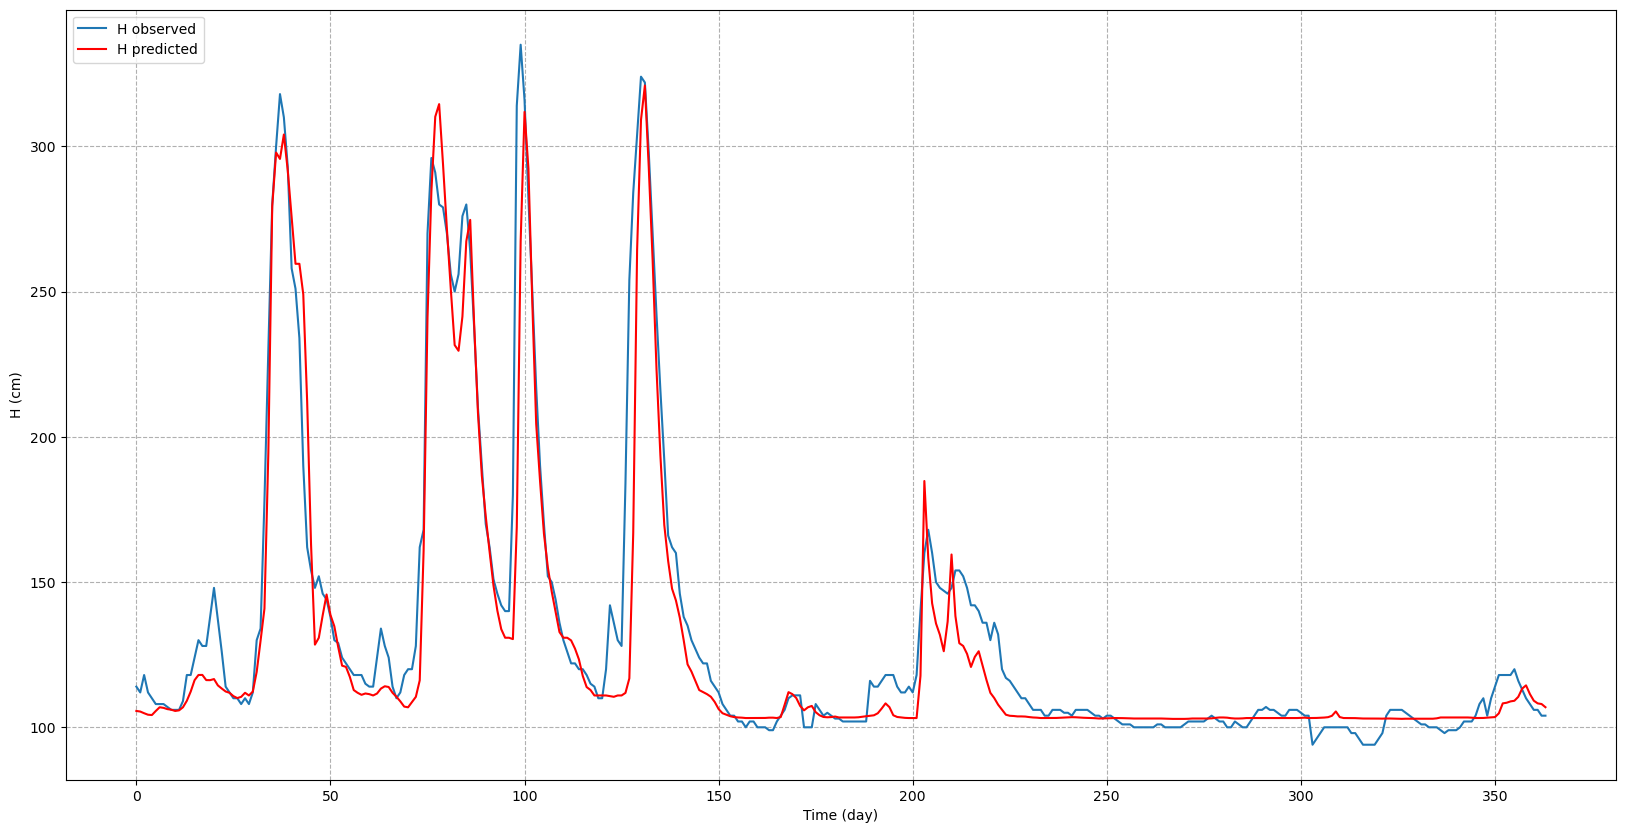

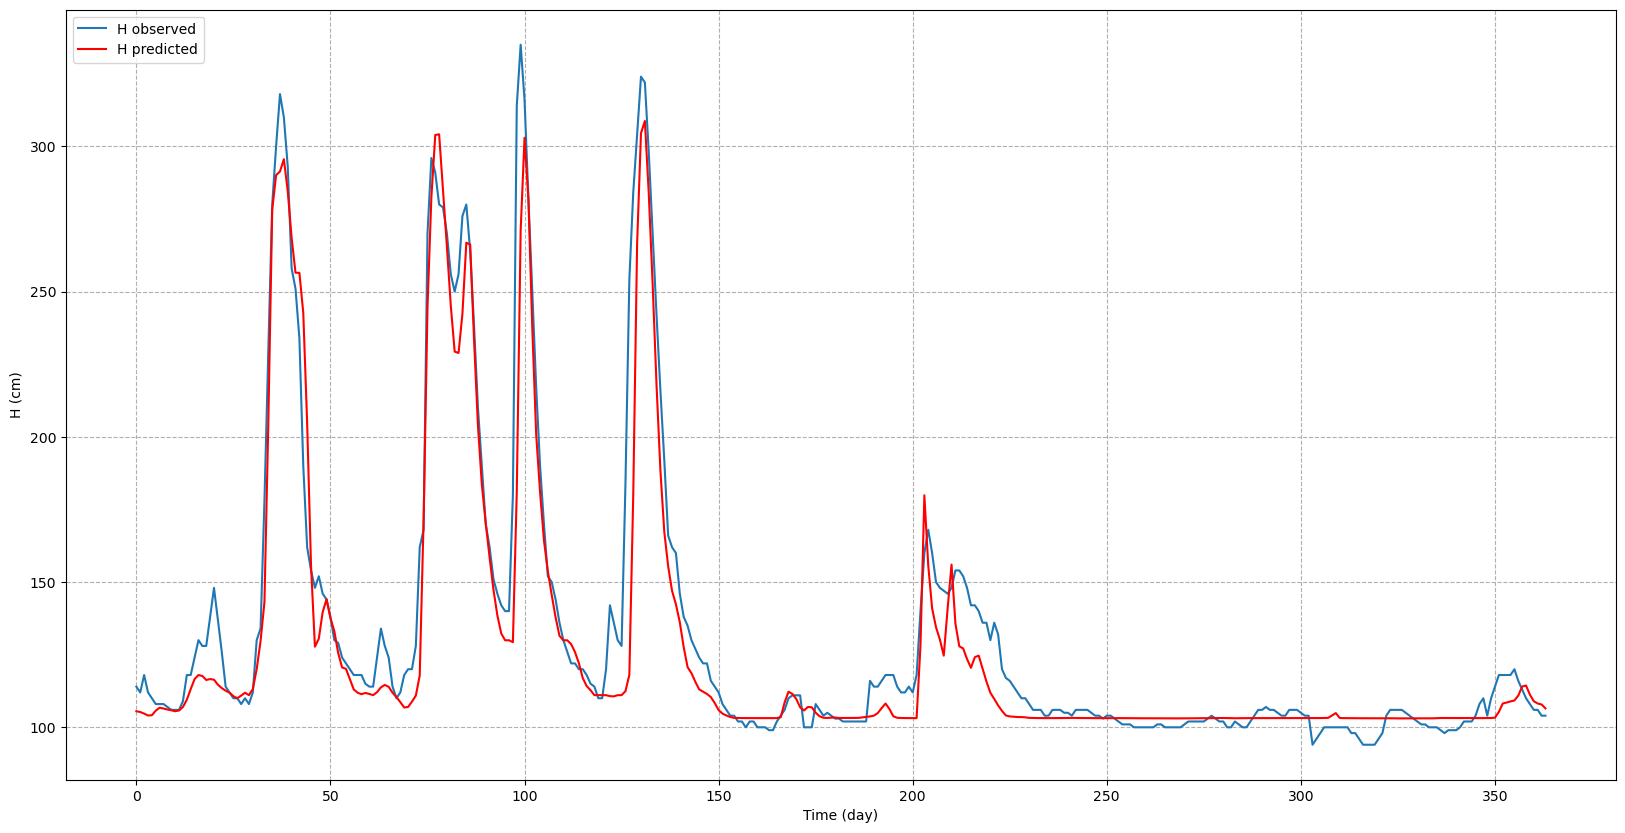

In [42]:
plot_prediction(prediction_bilstm, y_test)
plot_prediction(prediction_lstm, y_test)
plot_prediction(prediction_gru, y_test)

In [43]:
def print_evaluation2():
    nse_bilstm = he.evaluator(he.nse, prediction_bilstm, y_test)
    nse_lstm = he.evaluator(he.nse, prediction_lstm, y_test)
    nse_gru = he.evaluator(he.nse, prediction_gru, y_test)
    
    r2_bilstm = r2_score(prediction_bilstm, y_test)
    r2_lstm = r2_score(prediction_lstm, y_test)
    r2_gru = r2_score(prediction_gru, y_test)
    
    
    print('Nash-Sutcliffe Efficiency')
    print('Bidirectional LSTM:',f'{float(nse_bilstm):.2f}')
    print('LSTM:',f'{float(nse_lstm):.2f}')
    print('GRU:',f'{float(nse_gru):.2f}')
    print('')
    
    print('R2 score')
    print('Bidirectional LSTM:',f'{float(r2_bilstm):.2f}')
    print('LSTM:',f'{float(r2_lstm):.2f}')
    print('GRU:',f'{float(r2_gru):.2f}')
    print('')

In [44]:
print_evaluation2()

Nash-Sutcliffe Efficiency
Bidirectional LSTM: 0.90
LSTM: 0.89
GRU: 0.90

R2 score
Bidirectional LSTM: 0.89
LSTM: 0.88
GRU: 0.88



### CASE 2: FORECASTING DISCHARGES FOR THE GOSTKOWO STATION, ASSUMING THAT THIS WATER GAUGE PROFILE REPRESENTS AN INCOMPLETE SET OF DATA ON DISCHARGES.

In [45]:
train_dataset = hq['1981-01-01':'2003-12-31']
test_dataset = hq['2004-01-01':'2004-12-31']

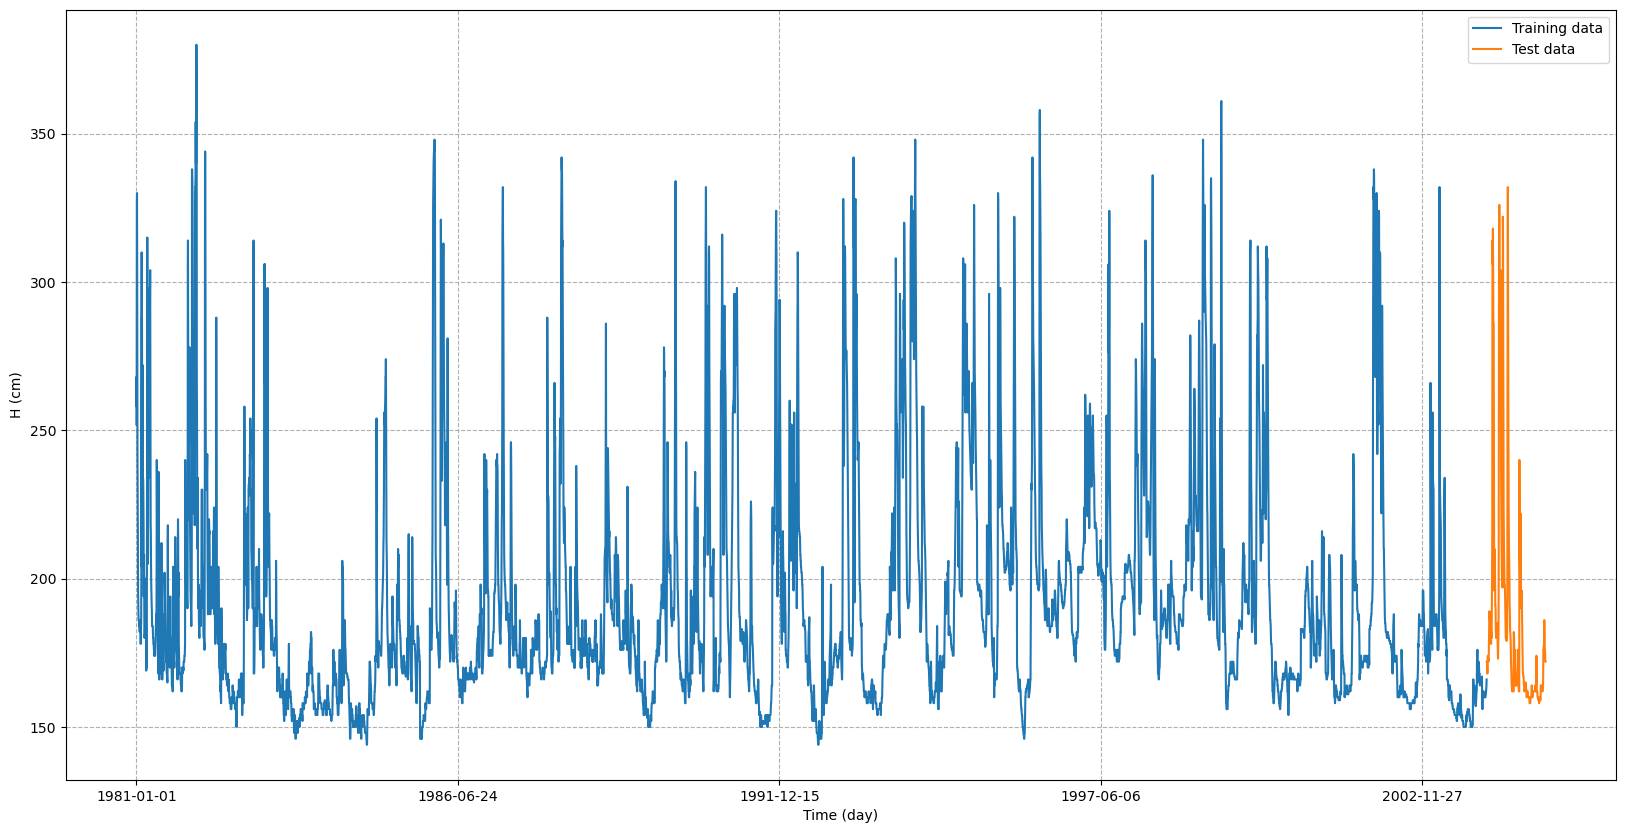

In [46]:
# Plot train and test data
plt.figure(figsize = (20, 10))
plt.plot(train_dataset.H_gostkowo)
plt.plot(test_dataset.H_gostkowo)
plt.xlabel('Time (day)')
plt.ylabel('H (cm)')
plt.legend(['Training data', 'Test data'], loc='upper right')
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_locator(ticker.AutoLocator())

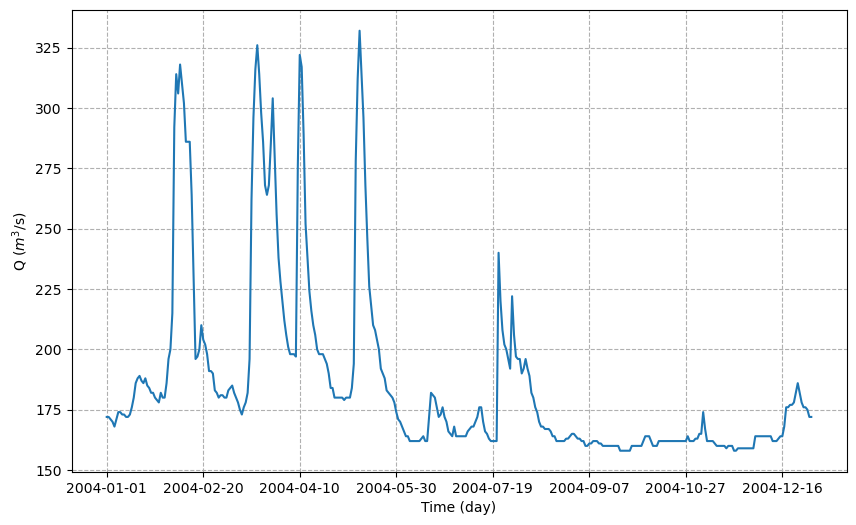

In [47]:
# Plot test data
plt.figure(figsize = (10, 6))
plt.plot(test_dataset.H_gostkowo)
plt.xlabel('Time (day)')
plt.ylabel('Q ($m^3$/s)')
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_locator(ticker.AutoLocator())

In [48]:
# Split train data to X and y
X_train = train_dataset.drop(['Q_gostkowo','H_gostkowo','Q_kaczkowo'], axis = 1)
y_train = train_dataset.loc[:,['H_gostkowo']]

# Split test data to X and y
X_test = test_dataset.drop(['Q_gostkowo','H_gostkowo','Q_kaczkowo'], axis = 1)
y_test = test_dataset.loc[:,['H_gostkowo']]

#### DECISION TREE MODEL

In [49]:
# Create regression tree model
model_dt = DecisionTreeRegressor()

# Create parameters grid
param_grid_dt = {
    'max_depth': [None, 2, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20, 40, 60],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}
# Grid search for optimization
grid_search_dt = GridSearchCV(model_dt, param_grid_dt, cv=5, scoring='neg_mean_absolute_error')
grid_search_dt.fit(X_train, y_train)

# Choosing the best model
best_model_dt = grid_search_dt.best_estimator_

In [50]:
print(best_model_dt)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)


In [51]:
# Make prediction
prediction_dt = best_model_dt.predict(X_test)

#### RANDOM FOREST MODEL

In [52]:
# Create regression forest model
model_rf = RandomForestRegressor()

# Grid search for optimization
param_grid_rf = {
    'n_estimators': [2, 5, 10, 20, 50, 100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20, 40, 60],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}
# Grid search for optimization
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='neg_mean_absolute_error')
grid_search_rf.fit(X_train, y_train.values.ravel())

# Choosing the best model
best_model_rf = grid_search_rf.best_estimator_

In [53]:
print(best_model_rf)

RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=60,
                      n_estimators=5)


In [54]:
# Make prediction
prediction_rf = best_model_rf.predict(X_test)

#### RESULTS

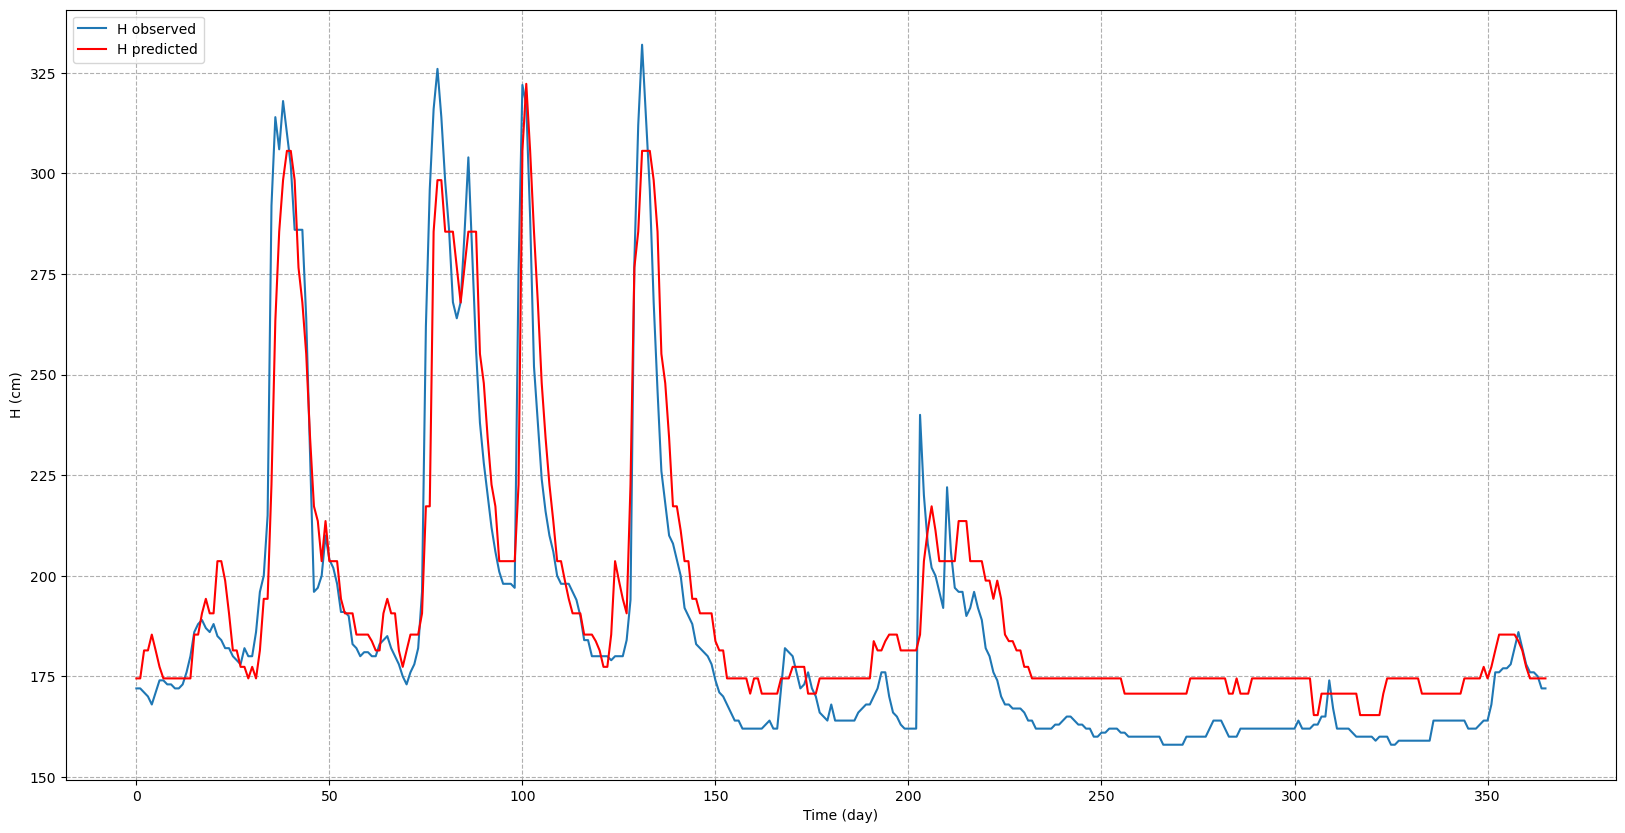

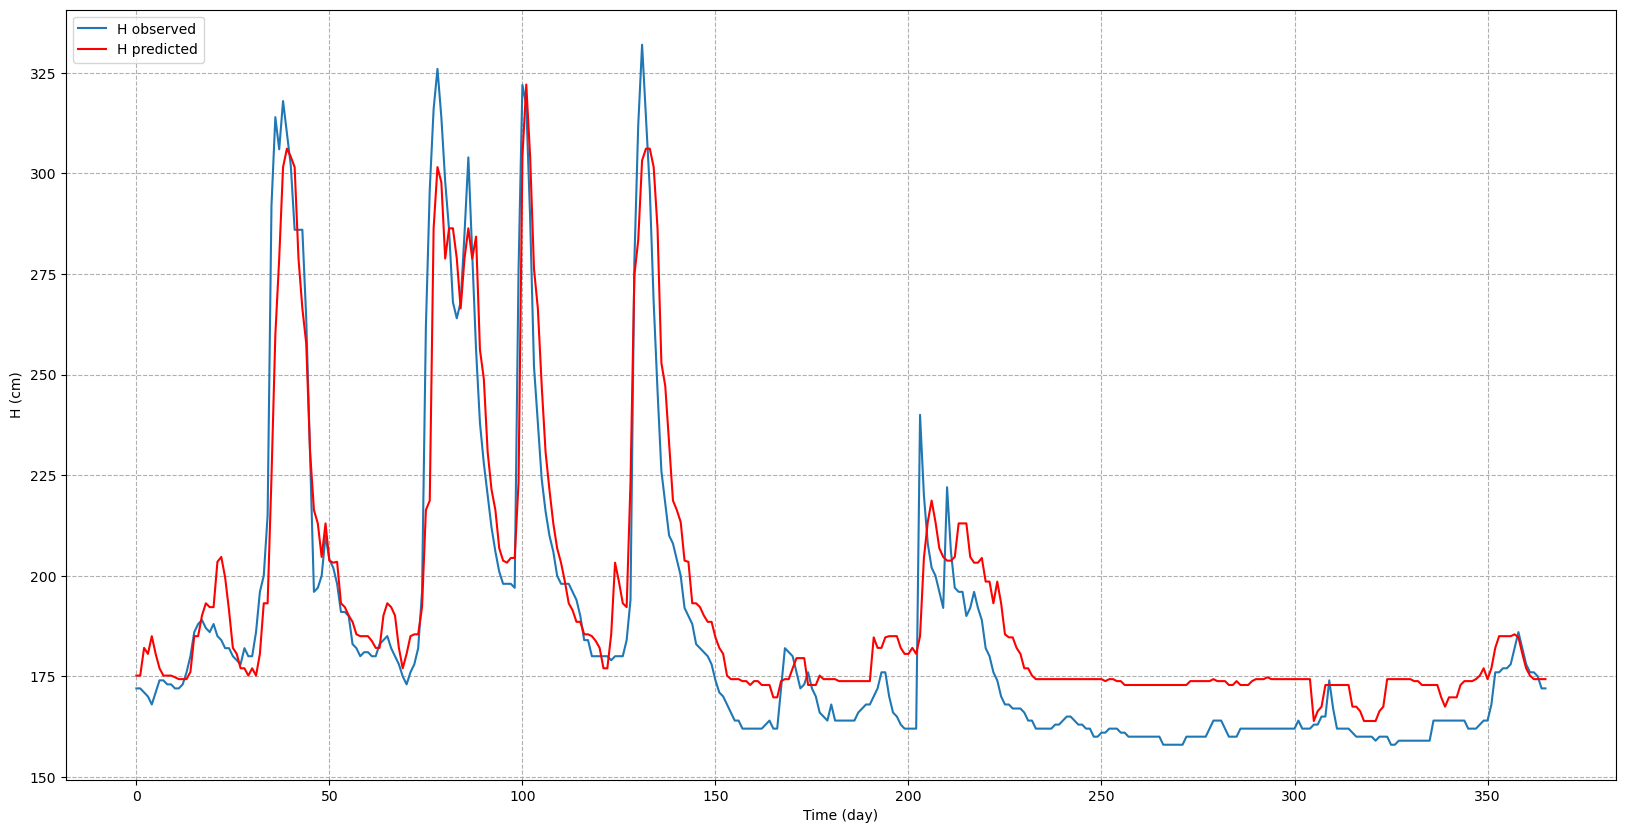

In [55]:
plot_prediction(prediction_dt, y_test)
plot_prediction(prediction_rf, y_test)

In [56]:
print_evaluation1()

Nash-Sutcliffe Efficiency
Decission Tree: 0.86
Random Forest: 0.86

R2 score
Decission Tree: 0.82
Random Forest: 0.82



#### RNN MODELS

In [57]:
X_train.head()

,H_kaczkowo
date,
1981-01-01,218.0
1981-01-02,238.0
1981-01-03,248.0
1981-01-04,266.0
1981-01-05,350.0


In [58]:
X_test.head()

,H_kaczkowo
date,
2004-01-01,108.0
2004-01-02,108.0
2004-01-03,114.0
2004-01-04,112.0
2004-01-05,118.0


In [59]:
y_train.head()

,H_gostkowo
date,
1981-01-01,252.0
1981-01-02,268.0
1981-01-03,258.0
1981-01-04,326.0
1981-01-05,330.0


In [60]:
y_test.head()

,H_gostkowo
date,
2004-01-01,172.0
2004-01-02,172.0
2004-01-03,171.0
2004-01-04,170.0
2004-01-05,168.0


In [61]:
# Scaler for input and output
X_scaler = MinMaxScaler(feature_range = (0,1))
y_scaler = MinMaxScaler(feature_range = (0,1))

in_scaler = X_scaler.fit(X_train)
out_scaler = y_scaler.fit(y_train)

X_train_norm = in_scaler.transform(X_train)
y_train_norm = out_scaler.transform(y_train)

X_test_norm = in_scaler.transform(X_test)
y_test_norm = out_scaler.transform(y_test)

In [62]:
DAYS = 2
X_test, y_test = create_dataset(X_test_norm, y_test_norm, DAYS)
X_train, y_train = create_dataset(X_train_norm, y_train_norm, DAYS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (8398, 2, 1)
y_train.shape:  (8398, 1)
X_test.shape:  (364, 2, 1)
y_test.shape:  (364, 1)


In [63]:
model_bilstm = create_model_bilstm(64, 64, X_train.shape[1], X_train.shape[2])
model_lstm = create_model(64, 64, LSTM, X_train.shape[1], X_train.shape[2])
model_gru = create_model(64, 64, GRU, X_train.shape[1], X_train.shape[2])

In [64]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/250
237/237 [==============================] - 13s 21ms/step - loss: 0.1101 - val_loss: 0.0947
Epoch 2/250
237/237 [==============================] - 3s 13ms/step - loss: 0.0793 - val_loss: 0.0529
Epoch 3/250
237/237 [==============================] - 3s 11ms/step - loss: 0.0579 - val_loss: 0.0399
Epoch 4/250
237/237 [==============================] - 3s 13ms/step - loss: 0.0565 - val_loss: 0.0396
Epoch 5/250
237/237 [==============================] - 3s 12ms/step - loss: 0.0569 - val_loss: 0.0397
Epoch 6/250
237/237 [==============================] - 3s 13ms/step - loss: 0.0566 - val_loss: 0.0398
Epoch 7/250
237/237 [==============================] - 3s 13ms/step - loss: 0.0564 - val_loss: 0.0394
Epoch 8/250
237/237 [==============================] - 3s 11ms/step - loss: 0.0565 - val_loss: 0.0395
Epoch 9/250
237/237 [==============================] - 3s 11ms/step - loss: 0.0563 - val_loss: 0.0395
Epoch 10/250
237/237 [==============================] - 3s 12ms/step - loss: 0.05

In [65]:
history_lstm = fit_model(model_lstm)

Epoch 1/250
237/237 [==============================] - 7s 12ms/step - loss: 0.1159 - val_loss: 0.1070
Epoch 2/250
237/237 [==============================] - 2s 8ms/step - loss: 0.0949 - val_loss: 0.0781
Epoch 3/250
237/237 [==============================] - 2s 10ms/step - loss: 0.0683 - val_loss: 0.0436
Epoch 4/250
237/237 [==============================] - 2s 10ms/step - loss: 0.0584 - val_loss: 0.0412
Epoch 5/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0587 - val_loss: 0.0407
Epoch 6/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0583 - val_loss: 0.0404
Epoch 7/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0583 - val_loss: 0.0402
Epoch 8/250
237/237 [==============================] - 2s 10ms/step - loss: 0.0579 - val_loss: 0.0403
Epoch 9/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0582 - val_loss: 0.0405
Epoch 10/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0583 - va

In [66]:
history_gru = fit_model(model_gru)

Epoch 1/250
237/237 [==============================] - 8s 13ms/step - loss: 0.1133 - val_loss: 0.0905
Epoch 2/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0784 - val_loss: 0.0518
Epoch 3/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0597 - val_loss: 0.0414
Epoch 4/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0586 - val_loss: 0.0404
Epoch 5/250
237/237 [==============================] - 2s 10ms/step - loss: 0.0587 - val_loss: 0.0403
Epoch 6/250
237/237 [==============================] - 2s 10ms/step - loss: 0.0581 - val_loss: 0.0403
Epoch 7/250
237/237 [==============================] - 3s 13ms/step - loss: 0.0578 - val_loss: 0.0399
Epoch 8/250
237/237 [==============================] - 4s 16ms/step - loss: 0.0580 - val_loss: 0.0400
Epoch 9/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0574 - val_loss: 0.0402
Epoch 10/250
237/237 [==============================] - 2s 9ms/step - loss: 0.0578 - v

In [67]:
#Inverse transform the target variable
y_test = y_scaler.inverse_transform(y_test)
y_train = y_scaler.inverse_transform(y_train)

In [68]:
print(y_test[:5])
print('-----------')
print(y_train[:5])

[[171.]
 [170.]
 [168.]
 [171.]
 [174.]]
-----------
[[258.]
 [326.]
 [330.]
 [308.]
 [260.]]


In [69]:
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

12/12 [==============================] - 1s 3ms/step


#### RESULTS

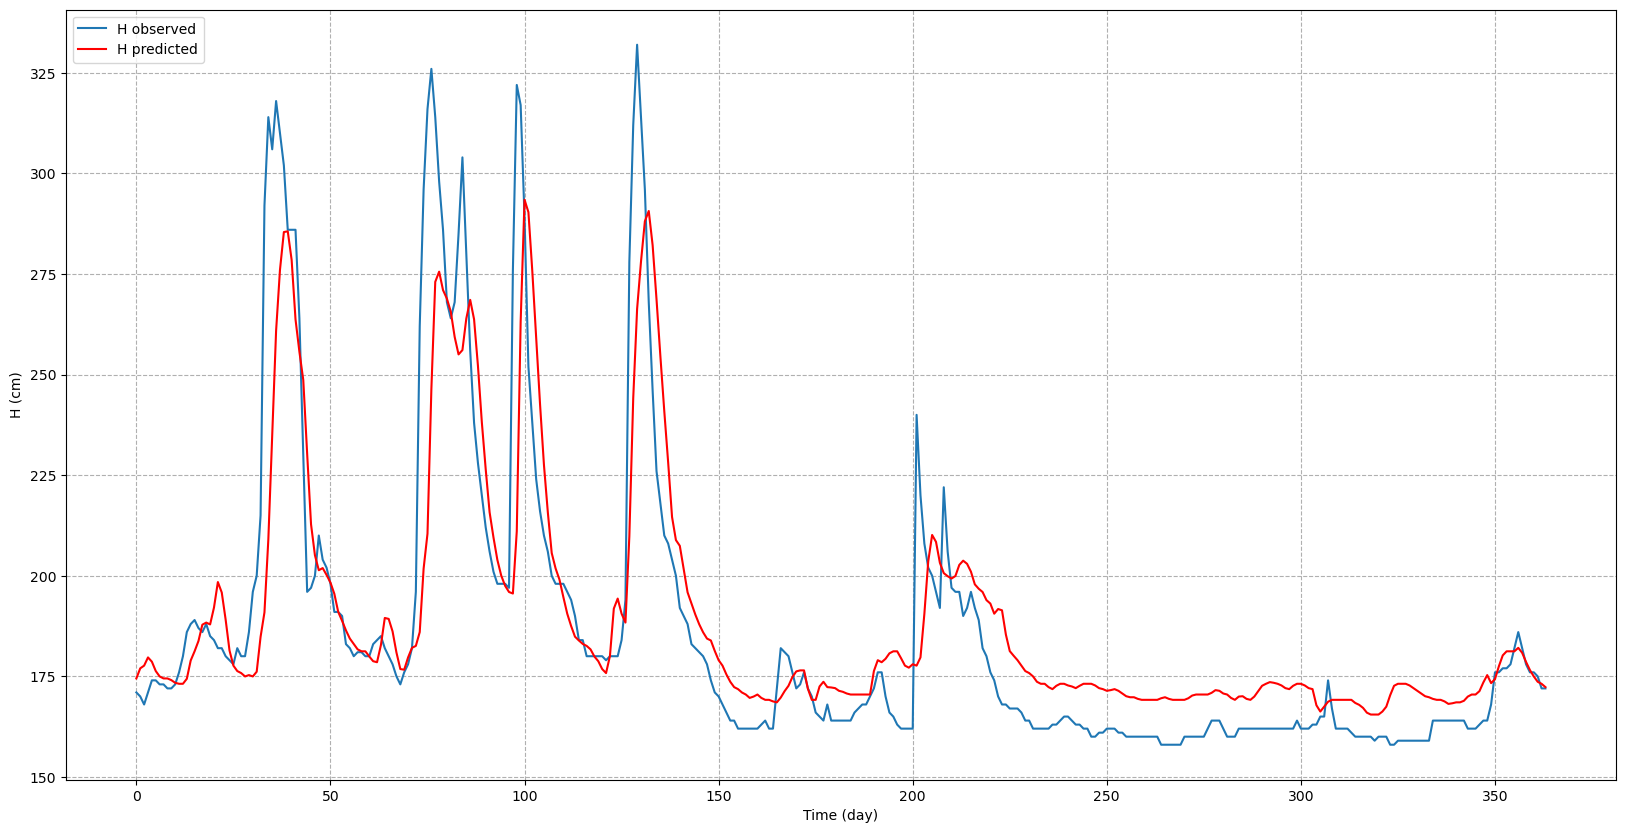

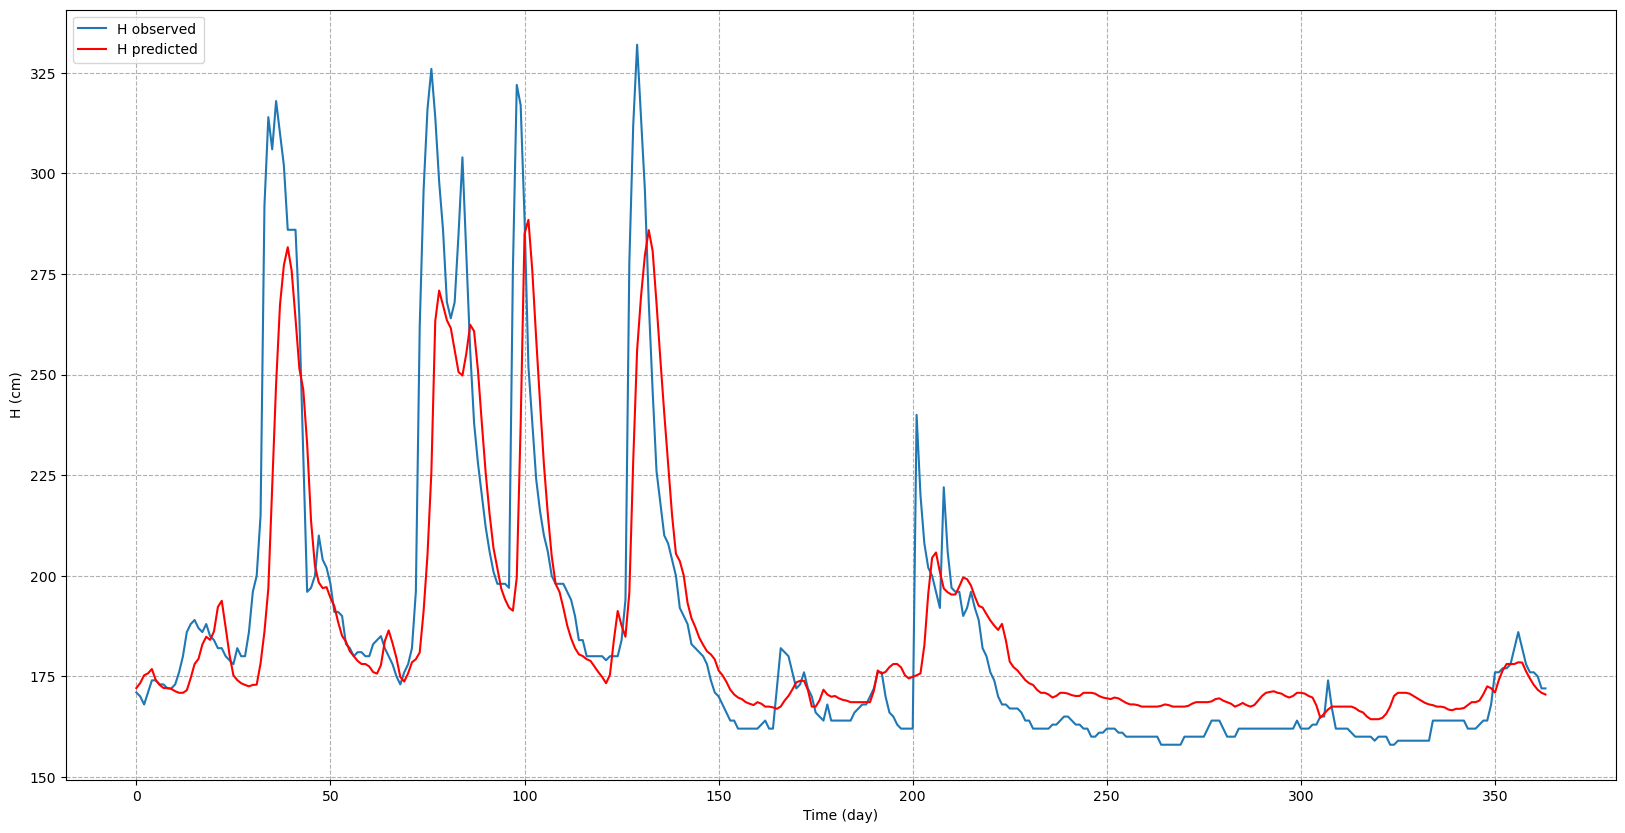

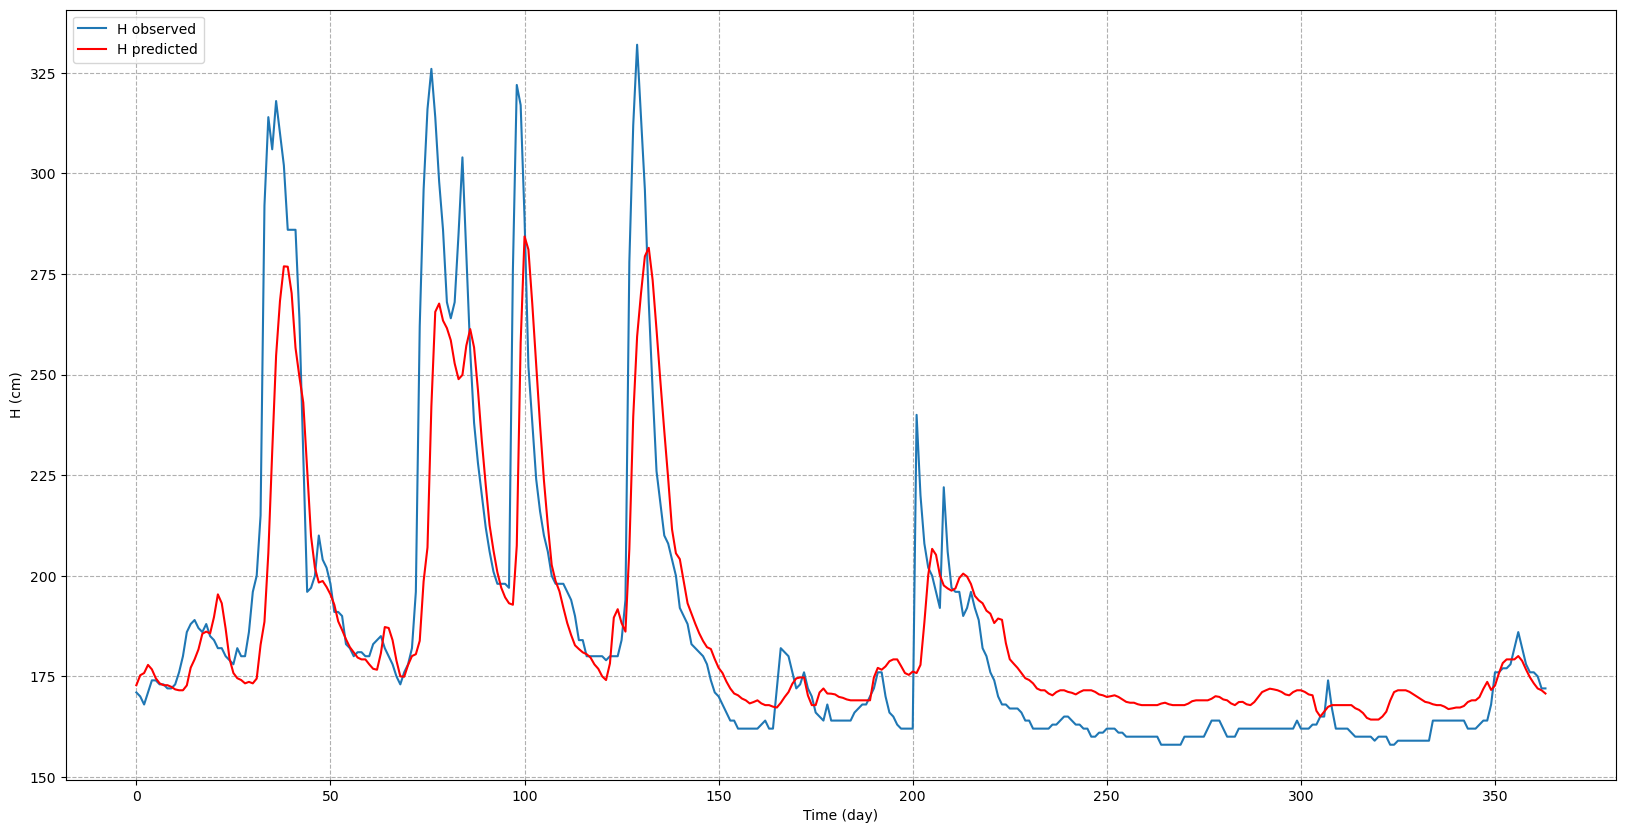

In [70]:
plot_prediction(prediction_bilstm, y_test)
plot_prediction(prediction_lstm, y_test)
plot_prediction(prediction_gru, y_test)

In [71]:
print_evaluation2()

Nash-Sutcliffe Efficiency
Bidirectional LSTM: 0.72
LSTM: 0.67
GRU: 0.72

R2 score
Bidirectional LSTM: 0.51
LSTM: 0.38
GRU: 0.43



## RESULTS AND DISCUSSION

The primary approach to assess compliance of hydrographs is through visual analysis. When examining the water level hydrographs for case 1, there is a noticeable agreement between the calculated and observed water levels. In case 2, better agreement is observed for the decision tree and random forest models. None of the RNN models provide satisfactory results for high water levels. In addition to visual assessment, two metrics, R2 and NSE, were utilized to evaluate the conformity of prognostic and test data. The coefficients of determination (R2) obtained for the recurrent neural networks in discharge forecasting were quite similar, ranging from 0.88 to 0.89. These values indicate that the simulation explains 88% to 89% of the observed variability in water levels, which is a good result. The decision tree and random forest models also yielded good outcomes, with R2 values of 0.86 and 0.85, respectively. Among the models, the BiLSTM network demonstrated the best performance in water level forecasting. In case 2, only the decision tree models and random forest can be considered good, with a value of 0.82. When considering the NSE coefficient values for case 1, it is observed that the RNN models provide the most accurate forecasts, with NSE values ranging from 0.89 to 0.90. The decision tree model and random forest also produced serious results, with NSE values of 0.88 and 0.87, respectively, indicating their strong prognostic capabilities. For case 2, the decision tree and random forest models achieved better results with NSE values of 0.86. However, the NSE values obtained from the RNN models, ranging from 0.67 to 0.72, indicate a satisfactory and reasonable fit between the model's results and the actual parameter values. Based on the conducted analyses, it is evident that machine learning models can be utilized to fill in missing data regarding river water levels. This is particularly feasible when there is a water gauge station located nearby, along the same river, with an extensive history of water level measurements.